In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from scipy.stats import norm, skew
warnings.filterwarnings('ignore')
%matplotlib inline
os.getcwd()

'/Users/mehdi/house_price'

import train and test set data

In [2]:
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

# dropping outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index).reset_index(drop=True)
len(train), len(test)

(1458, 1459)

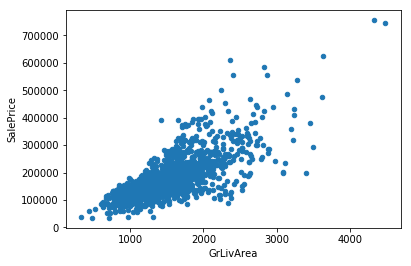

In [3]:
train.plot.scatter(x="GrLivArea", y="SalePrice")

Checking out the training and test data

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


removing the Id column from training and test sets

In [6]:
train_Id = train["Id"]
test_Id = test["Id"]
train = train.drop("Id", axis=1)
test = test.drop("Id", axis=1)

separating the SalePrice (target variable) column in training data

In [7]:
price = train["SalePrice"]
train.drop("SalePrice", inplace=True, axis=1)

# Feature manipulation

Here, we go through the features in our datasets and look for and fix the followings:
- features that are stored as numerical but are categorical in nature (and vice versa)
- features with missing values

First, let's concatenate training and test set data. This way we make sure any change to features is applied the same way to both datasets.

In [8]:
all_X = pd.concat([train, test]).reset_index(drop=True)
len_train = len(train)
# all_X.iloc[:len_train, :] is the training data and all_X.iloc[len_train:, :] is the test set.
all_X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


identifying numerical and categorical features

In [9]:
features = all_X.columns
num_features = all_X.select_dtypes(include="number").columns
cat_features = all_X.select_dtypes(exclude="number").columns
print("Numerical features:\n", num_features.tolist())
print("Categorical features:\n", cat_features.tolist())

Numerical features:
 ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
Categorical features:
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageTyp

MSSubClass is categorical but is stored as numerical, so we will change it.

In [10]:
all_X["MSSubClass"] = all_X["MSSubClass"].astype(str)

In [11]:
features = all_X.columns
num_features = all_X.select_dtypes(include="number").columns
cat_features = all_X.select_dtypes(include="object").columns

Let's move to handling the missing values

In [12]:
miss_data_features = features[all_X.isnull().sum()>0]
print("Features with missing values:", miss_data_features.tolist())

Features with missing values: ['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


Looking at the desciption of features (as provided by the documentation), we fill the missing values.
For some features it is clear by the documentation what the missing value means, e.g. Nan "PoolQC" means no pool. 
For some we fill Nans with the median or mode of the same feature for houses in the same neighborhood.

In [13]:
replace_with_typ = ["Functional"]
replace_with_median = ["LotFrontage"]
replace_with_mode = ["MSZoning", "Exterior1st", "Exterior2nd", "Electrical",
                     "KitchenQual", "SaleType", "Utilities", "GarageYrBlt"]
replace_with_None = ["Alley", "MasVnrType", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
                  "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", 
                   "GarageCond", "PoolQC", "Fence", "MiscFeature"]
replace_with_zero = ["MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF",
                     "BsmtFullBath", "BsmtHalfBath", "GarageCars", "GarageArea"]

replaced = ["LotFrontage", "MSZoning", "Exterior1st", "Exterior2nd", "Electrical", "KitchenQual", "SaleType",
           "Utilities", "GarageYrBlt"]

for feature in replaced:
    all_X[feature + "_missing"] = 1 * all_X[feature].isnull()

for feature in replace_with_typ:
    all_X[feature].fillna("Typ", inplace=True)

for feature in replace_with_median:
    all_X[feature] = all_X.groupby("Neighborhood")[feature].transform(lambda s: s.fillna(s.median()))

for feature in replace_with_mode:
    all_X[feature] = all_X.groupby("Neighborhood")[feature].transform(lambda s: s.fillna(s.mode()[0]))
    
for feature in replace_with_None:
    all_X[feature].fillna("None", inplace=True)

for feature in replace_with_zero:
    all_X[feature].fillna(0, inplace=True)

Making sure that everything is filled

In [14]:
all_X.isnull().sum().sum()

0

In [15]:
features = all_X.columns
num_features = all_X.select_dtypes(include="number").columns
cat_features = all_X.select_dtypes(include="object").columns

looking at "Utilities", just one single observation has a different value from the rest. So, it doesn't add to the predictive power of our model. So, we drop it. 

In [16]:
all_X.drop(["Utilities", "Utilities_missing"], axis=1, inplace=True)

In [17]:
features = all_X.columns
num_features = all_X.select_dtypes(include="number").columns
cat_features = all_X.select_dtypes(include="object").columns

# Failed attempt
## Changing quality features to numerical labels

I had an idea that chaning features that represent quality-like information to labels 0,1,2,... would help the learning process. My expectation was that giving the ordering, e.g. bad-->0 good-->1 excellent-->2, would reinforce the ordering of bad < good < excellent. However, after implementing this, the error of validation data didn't change at all. It even became slightly worse overall, but the change was in the margine of errors.     
We can also change 2-level categorical features to 0-1 levels.

In [18]:
# print("number of unique values in:")
# for feature in cat_features:
#     print(feature+":", all_X[feature].describe()["unique"])

all_X["Street"]= (all_X["Street"]=="Pave")*1
all_X["CentralAir"] = (all_X["CentralAir"]=="Y")*1

# # why we shouldnt use LabelEncoder?

# mapping = {"Reg":0, "IR1":1, "IR2":2, "IR3":3}
# all_X["LotShape"] = all_X["LotShape"].map(lambda s: mapping[s])

# mapping = {"Gtl":0, "Mod":1, "Sev":2}
# all_X["LandSlope"] = all_X["LandSlope"].map(lambda s: mapping[s])


# mapping = {"Po":0, "Fa":1, "TA":2, "Gd":3, "Ex":4}
# all_X["ExterQual"] = all_X["ExterQual"].map(lambda s: mapping[s])


# mapping = {"Po":0, "Fa":1, "TA":2, "Gd":3, "Ex":4}
# all_X["ExterCond"] = all_X["ExterCond"].map(lambda s: mapping[s])


# mapping = {"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5}
# all_X["BsmtQual"] = all_X["BsmtQual"].map(lambda s: mapping[s])


# mapping = {"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5}
# all_X["BsmtCond"] = all_X["BsmtCond"].map(lambda s: mapping[s])


# mapping = {"None":0, "No":1, "Mn":2, "Av":3, "Gd":4}
# all_X["BsmtExposure"] = all_X["BsmtExposure"].map(lambda s: mapping[s])


# mapping = {"None":0, "Unf":1, "LwQ":2, "Rec":3, "BLQ":4, "ALQ":5, "GLQ":6}
# all_X["BsmtFinType1"] = all_X["BsmtFinType1"].map(lambda s: mapping[s])

# mapping = {"None":0, "Unf":1, "LwQ":2, "Rec":3, "BLQ":4, "ALQ":5, "GLQ":6}
# all_X["BsmtFinType2"] = all_X["BsmtFinType2"].map(lambda s: mapping[s])


# mapping = {"Po":0, "Fa":1, "TA":2, "Gd":3, "Ex":4}
# all_X["HeatingQC"] = all_X["HeatingQC"].map(lambda s: mapping[s])

# mapping = {"Po":0, "Fa":1, "TA":2, "Gd":3, "Ex":4}
# all_X["KitchenQual"] = all_X["KitchenQual"].map(lambda s: mapping[s])


# mapping = {"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5}
# all_X["FireplaceQu"] = all_X["FireplaceQu"].map(lambda s: mapping[s])


# mapping = {"None":0, "Unf":1, "RFn":2, "Fin":3}
# all_X["GarageFinish"] = all_X["GarageFinish"].map(lambda s: mapping[s])


# mapping = {"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5}
# all_X["GarageQual"] = all_X["GarageQual"].map(lambda s: mapping[s])


# mapping = {"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5}
# all_X["GarageCond"] = all_X["GarageCond"].map(lambda s: mapping[s])


# mapping = {"None":0, "Fa":1, "TA":2, "Gd":3, "Ex":4}
# all_X["PoolQC"] = all_X["PoolQC"].map(lambda s: mapping[s])

# Final features

In [19]:
features = all_X.columns
num_features = all_X.select_dtypes(include="number").columns
cat_features = all_X.select_dtypes(exclude="number").columns
print("Numerical features:\n", num_features.tolist())
print("Categorical features:\n", cat_features.tolist())

Numerical features:
 ['LotFrontage', 'LotArea', 'Street', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'LotFrontage_missing', 'MSZoning_missing', 'Exterior1st_missing', 'Exterior2nd_missing', 'Electrical_missing', 'KitchenQual_missing', 'SaleType_missing', 'GarageYrBlt_missing']
Categorical features:
 ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 

# Numerical features normalization

Let's rescale some of the features by log-transformation.

In [20]:
log_transform_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
                          'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                          'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                          '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
for feature in log_transform_features:
    all_X[feature] = np.log1p(all_X[feature])

let's rescale numerical features to have zero mean and std 1. 

In [21]:
for feature in num_features:
    mean, std = all_X[feature].mean(), all_X[feature].std()
    all_X[feature] = (all_X[feature]- mean)/std
all_X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,SaleType,SaleCondition,LotFrontage_missing,MSZoning_missing,Exterior1st_missing,Exterior2nd_missing,Electrical_missing,KitchenQual_missing,SaleType_missing,GarageYrBlt_missing
0,60,RL,-0.049875,-0.101744,0.06426,None,Reg,Lvl,Inside,Gtl,...,WD,Normal,-0.447045,-0.03705,-0.018515,-0.018515,-0.018515,-0.018515,-0.018515,-0.240064
1,20,RL,0.574926,0.149410,0.06426,None,Reg,Lvl,FR2,Gtl,...,WD,Normal,-0.447045,-0.03705,-0.018515,-0.018515,-0.018515,-0.018515,-0.018515,-0.240064
2,60,RL,0.085741,0.461603,0.06426,None,IR1,Lvl,Inside,Gtl,...,WD,Normal,-0.447045,-0.03705,-0.018515,-0.018515,-0.018515,-0.018515,-0.018515,-0.240064
3,70,RL,-0.290226,0.139131,0.06426,None,IR1,Lvl,Corner,Gtl,...,WD,Abnorml,-0.447045,-0.03705,-0.018515,-0.018515,-0.018515,-0.018515,-0.018515,-0.240064
4,60,RL,0.721984,0.928292,0.06426,None,IR1,Lvl,FR2,Gtl,...,WD,Normal,-0.447045,-0.03705,-0.018515,-0.018515,-0.018515,-0.018515,-0.018515,-0.240064


categorical features has to get modified, so we can input this data to a regression model. 
We use one-hot method

In [22]:
print("number of features in training data = ", len(all_X.columns))
one_hot_all_X = pd.get_dummies(all_X)
print("number of features after adding dummy variables = ", len(one_hot_all_X.columns))

number of features in training data =  86
number of features after adding dummy variables =  320


Finally, let's separate training and test data.

In [23]:
X_allF = one_hot_all_X.iloc[:len_train, :]
X_allF_test = one_hot_all_X.iloc[len_train:, :]
len(X_allF), len(X_allF_test)

(1458, 1459)

# Manipulation of target variable

Let's see the distribution of the target variable, SalePrice 

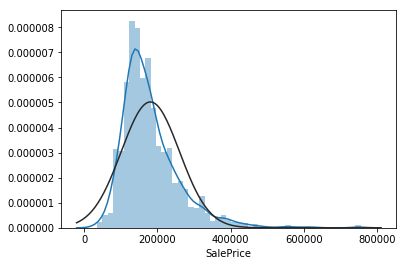

In [24]:
sns.distplot(price, fit=norm);

As we can see it's far from normal distribution. So it's better to perform a transformation to make it more Gaussian.

We apply a log transformation. This intuitively makes sense, since we expect the ratio of prices to be relevant. So log(price) is a better variable to work with. Also, the testing of the competition suggest the log transformation.

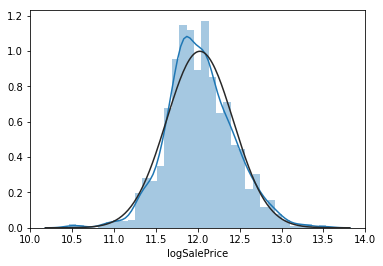

In [25]:
log_price = np.log(price).rename("logSalePrice")
sns.distplot(log_price, fit=norm)

Now It's looking more like a normal distribution. Let's also renormalize the logSalePrice data.

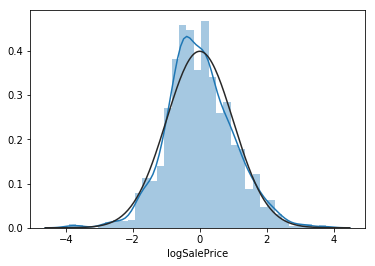

In [26]:
log_price_mean = log_price.mean()
log_price_std = log_price.std()
y = (log_price - log_price_mean)/log_price_std
sns.distplot(y, fit=norm)
# it is important to remember the manipulation on labels, since we have to do the reverse
# on our prediction to recover sale prices in $. 

# Feature selection
After experimenting with a number of models with the current training data, it seems that we get a better performance by removing some features. That's what we do here!
We use a Lasso model for feature selection.
We can use the ''alpha'' parameter to control how many features are included.

In [27]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

def reduce_feature(X, X_test, y, alpha):
    select = SelectFromModel(Lasso(alpha=alpha))
    X_reduced = select.fit_transform(X, y)
    X_test_reduced = select.transform(X_test)
    return X_reduced, X_test_reduced

X, X_test = reduce_feature(X_allF, X_allF_test, y, 0.001)
X.shape, X_test.shape

((1458, 120), (1459, 120))

# Modelling

In [28]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


def rmse_cv(model):
    kf = KFold(5, shuffle=True, random_state=21).split(X)
    rmse = log_price_std * np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))
    return round(rmse.mean(),4), round(rmse.std(),4)

def rmse_train_cv(model):
    model_ = clone(model)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=3)
    model_.fit(X_train, y_train)
    train_error = log_price_std * np.sqrt(mean_squared_error(model_.predict(X_train), y_train))
    val_error = log_price_std * np.sqrt(mean_squared_error(model_.predict(X_val), y_val))
    return round(train_error,4), round(val_error,4)

### Knn

MSE on training: 0.1536 validation: 0.1646


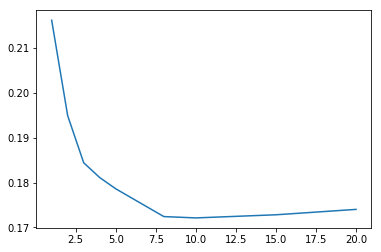

In [29]:
from sklearn.neighbors import KNeighborsRegressor

ns = [1,2,3,4,5,8,10,15,20]
rmse = []
for n in ns:
    model = KNeighborsRegressor(n_neighbors=n)
    rmse.append(rmse_cv(model)[0])

plt.plot(ns, rmse)

best_n = min(zip(rmse, ns))[1]
model_Knn = KNeighborsRegressor(n_neighbors=best_n)
print("MSE on training: %.4f validation: %.4f" %rmse_train_cv(model_Knn))

### Ridge

In [30]:
from sklearn.linear_model import RidgeCV

alphas =[0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0]
model_Ridge = RidgeCV(alphas=alphas).fit(X, y)

print("MSE on training: %.4f validation: %.4f" %rmse_train_cv(model_Ridge))

MSE on training: 0.0933 validation: 0.1121


### Lasso

In [31]:
from sklearn.linear_model import LassoCV

alphas =[0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]
model_Lasso = LassoCV(alphas = alphas).fit(X, y)

print("MSE on training: %.4f validation: %.4f" %rmse_train_cv(model_Lasso))

MSE on training: 0.0927 validation: 0.1120


### Elastic Net

In [32]:
from sklearn.linear_model import ElasticNetCV

alphas =[0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0]
model_ENet = ElasticNetCV(l1_ratio=(0.1,0.3,0.5,0.7,0.9,0.95,0.99, 0.999),
                          alphas=alphas).fit(X, y)

print("MSE on training: %.4f validation: %.4f" %rmse_train_cv(model_ENet))

MSE on training: 0.0941 validation: 0.1127


### XGBboost

In [33]:
from xgboost import XGBRegressor

ns = [50,100,200,500]
learning_rates = [0.01,0.05,0.1]
rmse = []
for n in ns:
    for lr in learning_rates:
        model_XGB = XGBRegressor(n_estimators=n, learning_rate=lr, random_state=51)
        rmse.append((rmse_cv(model_XGB)[0], n, lr))

In [34]:
_, best_n, best_learning_rate = min(rmse)
model_XGB = XGBRegressor(n_estimators=best_n, learning_rate=best_learning_rate, random_state=51).fit(X, y)

print("MSE on training: %.4f validation: %.4f" %rmse_train_cv(model_XGB))

MSE on training: 0.0574 validation: 0.1178


### SVM

In [35]:
from sklearn import svm

model_svm = svm.SVR(kernel="linear", C=10).fit(X, y)
print("MSE on training: %.4f validation: %.4f" %rmse_train_cv(model_svm))

MSE on training: 0.0953 validation: 0.1132


### Bagg (Ridge)

In [36]:
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor

model_Bagg = BaggingRegressor(model_Ridge, n_estimators=20, max_samples=0.8, max_features=1.0).fit(X, y)

print("MSE on training: %.4f validation: %.4f" %rmse_train_cv(model_Bagg))

MSE on training: 0.0961 validation: 0.1114


### Gradient Boosting Regressor
##### (sklearn implementation of xgboost)

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

ns = [100, 300, 500]
rmse = []
for n in ns:
    model = GradientBoostingRegressor(n_estimators=n)
    rmse.append(rmse_cv(model)[0])

best_n = min(zip(rmse, ns))[1]
model_GBR = GradientBoostingRegressor(n_estimators=best_n).fit(X, y)

print("MSE on training: %.4f validation: %.4f" %rmse_train_cv(model_GBR))

MSE on training: 0.0338 validation: 0.1206


### Random Forest Regressor

In [38]:
from sklearn.ensemble import RandomForestRegressor


model_RFR = RandomForestRegressor(n_estimators=1000, max_features=20, max_depth=7).fit(X, y)

print("MSE on training: %.4f validation: %.4f" %rmse_train_cv(model_RFR))

MSE on training: 0.0973 validation: 0.1420


### Average of Models

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone


class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models, ratio="equal"):
        self.models = models
        if ratio=="equal":
            self.ratio = np.ones(len(models))/len(models)
        else:
            self.ratio = np.array(ratio)
        assert len(self.ratio)==len(self.models), "models and ratio do not have the same length"

    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.sum(predictions*self.ratio, axis=1)

In [40]:
models = [model_Bagg, model_Ridge, model_XGB, model_svm]
average_model = AveragingModels(models=models, ratio=[0.4,0.2,0.2,0.2]).fit(X, y)

print("MSE on training: %.4f validation: %.4f" %rmse_train_cv(average_model))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator AveragingModels modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


MSE on training: 0.0846 validation: 0.1096


In [41]:
prediction = average_model.predict(X_test)

In [42]:
import datetime

date = str(datetime.date.today())
my_submission = pd.DataFrame({"Id":test_Id, "SalePrice": np.exp(prediction*log_price_std + log_price_mean)})
if input()=="y":
    my_submission.to_csv("submission"+date+".csv", index=False)

y
